# **Tagup Data Science Exercise**

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines. These very expensive machines have three operating modes: normal, faulty and failed. The machines run all the time, and usually they are in normal mode. However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible. This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines. When a machine is operating in normal mode the data behaves in a fairly predictable way, but with a moderate amount of noise. Before a machine fails it will ramp into faulty mode, during which the data appears visibly quite different. Finally, when a machine fails it enters a third, and distinctly different, failed mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

**Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine.** Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.

A few notes to help:

1. A good place to start is by addressing the noise due to communication errors.
2. Feel free to use any libraries you like. Your final results should be presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!



#### **Import data**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Lambda, Input
from keras.models import Sequential, Model
from keras import backend as K
from keras.callbacks import History 
import wget

In [2]:
# Load the dataset - machine_0~19.csv
for x in range(20):
    url='https://raw.githubusercontent.com/linlcc/TagUp/master/data/machine_%s.csv'%x
    wget.download(url)

#### **Visualize the raw data**
There are five columns in every csv file, it comes with timestamp and four kinds of timeseries data. For the plot, we can see there are a lot of noise in every timeseries data.

,Unnamed: 0,0,1,2,3
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


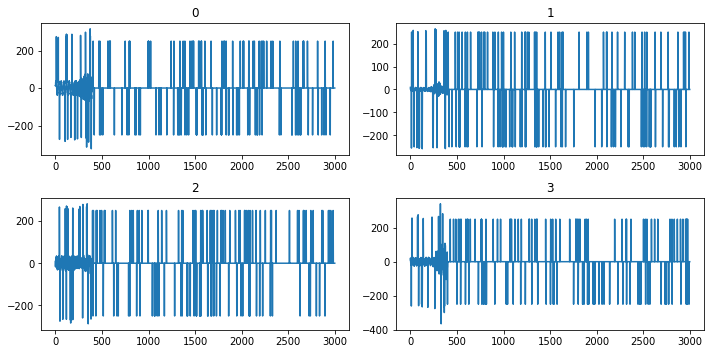

In [3]:
# Import data
df = pd.read_csv("machine_0.csv")
display(df.head(5))

# plot the training data with 4 signals
fig,axs=plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(df['0'])
axs[0,0].set_title("0")
axs[0,1].plot(df['1'])
axs[0,1].set_title("1")
axs[1,0].plot(df['2'])
axs[1,0].set_title("2")
axs[1,1].plot(df['3'])
axs[1,1].set_title("3")
fig.tight_layout(pad=1.0)
plt.show()

#### **Data cleansing**
As we see above, there is a lot of noise or outliers in the dataset. So, We need to do some processes to clean and prepare for the training set. 

1. Apply 3σ Rule to find out the outliers
2. Filter out outliers **(as first four graphs)** and failed state data (which is close to 0) **(as second four graphs)**
3. Average the half of the filtered data, I took only half of the filtered data(because  of filtered data still contains normal and faulty data) to ensure I use the normal state data for averaging
4. Replace the outliers with the average values that we just obtained in the original dataset, then filter out "failed" state data and take half of it as the training set. **(as last four graphs)**

We can see from the example graph below, the training data only contains around 200 data points, which are already filtered out "failed" data and replace outliers with average values.

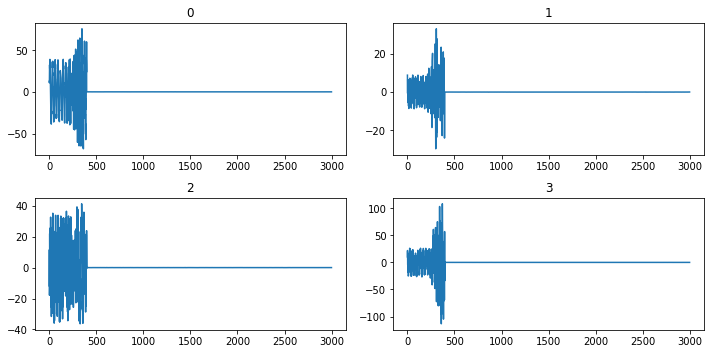

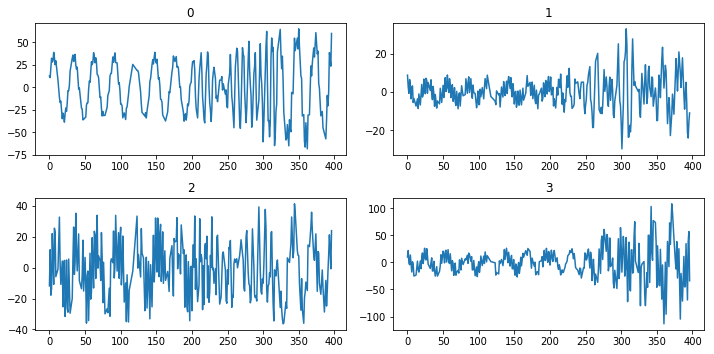

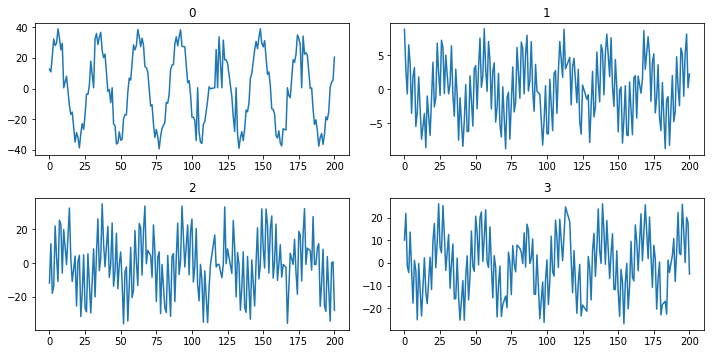

In [4]:
# Import data
df = pd.read_csv("machine_0.csv")
mod=df
a=mod.mean()+3*mod.std() # 3σ Rule outlier detection

# for replace the oulier data in "nomal" operation data
# average the data w/o the outliers in "normal" operation data
for y in range(4):
  mod=mod.drop(mod[(abs(mod["%s"%y]) > a[y])].index)

fig,axs=plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(mod['0'])
axs[0,0].set_title("0")
axs[0,1].plot(mod['1'])
axs[0,1].set_title("1")
axs[1,0].plot(mod['2'])
axs[1,0].set_title("2")
axs[1,1].plot(mod['3'])
axs[1,1].set_title("3")
fig.tight_layout(pad=1.0)
plt.show()
  
for y in range(4):
  mod=mod.drop(mod[(abs(mod["%s"%y]) < 0.1)].index)

fig,axs=plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(mod['0'])
axs[0,0].set_title("0")
axs[0,1].plot(mod['1'])
axs[0,1].set_title("1")
axs[1,0].plot(mod['2'])
axs[1,0].set_title("2")
axs[1,1].plot(mod['3'])
axs[1,1].set_title("3")
fig.tight_layout(pad=1.0)
plt.show()

mod=mod[:round(len(mod)*0.5)]

# delete the failed data and replace the outliers in normal data with above average data
# then only take half of result data as training data
for y in range(4):
  for z in range(len(df)):
    if abs(df.iloc[z, y+1]) > a[y]:
      df.iloc[z, y+1]=mod.mean()[y]
  df = df.drop(df[(abs(df["%s"%y]) < 0.1)].index)
df=df[:round(len(df)*0.5)]

# plot the training data with 4 signals
fig,axs=plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(df['0'])
axs[0,0].set_title("0")
axs[0,1].plot(df['1'])
axs[0,1].set_title("1")
axs[1,0].plot(df['2'])
axs[1,0].set_title("2")
axs[1,1].plot(df['3'])
axs[1,1].set_title("3")
fig.tight_layout(pad=1.0)
plt.show()

Here I separated all files we have into training data (machine_0.csv ~ machine_17.csv) and testing data (machine_18.csv ~ machine_19.csv)

I apply the procedure that I mentioned above to clean and replace outliers for training files (0~17), and create a training set for later model input.


In [5]:
values=pd.DataFrame()
for x in range(20):
  temp= pd.read_csv("machine_%s.csv"%x) 
  a=temp.mean()+3*temp.std() # 3σ Rule outlier detection
  mod=temp
  for y in range(4):
    mod=mod.drop(mod[(abs(mod["%s"%y]) > a[y])|(abs(mod["%s"%y]) < 0.1)].index)
  mod=mod[:round(len(mod)*0.5)]

  for y in range(4):
    for z in range(len(temp)):
      if abs(temp.iloc[z, y+1]) > a[y]:
        temp.iloc[z, y+1]=mod.mean()[y]
    temp = temp.drop(temp[(abs(temp["%s"%y]) < 0.1)].index)
  temp=temp[:round(len(temp)*0.5)]
  values=values.append(temp)

values=values.drop(values.columns[0],axis=1)

#### **Transform unsupervised problem into supervised problem**
Before I apply to any machine learning, time series forecasting problems must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences.

So, I created a function to transform a time series dataset into a supervised learning dataset.

Below is a simple example to explain how this function works.
For example:

Input data
```
index var(t)
  1    20
  2    35
  3    45
  4    56 
```
Output data
```
index var(t-1) var(t)
  2      20      35
  3      35      45
  4      45      56 
```


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Then, I can start to prepare the training data by normalization and transformation.

I used 2 previous time data with 4 variates (signals) in each timestamp. The result training data is like the below output shows.



In [7]:
# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
reframed.head(5)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
2,0.606006,0.525719,0.336850,0.528560,0.593466,0.432180,0.655451,0.593674,0.665123,0.377667,0.254623,0.465519
3,0.593466,0.432180,0.655451,0.593674,0.665123,0.377667,0.254623,0.465519,0.743486,0.490127,0.313813,0.449519
4,0.665123,0.377667,0.254623,0.465519,0.743486,0.490127,0.313813,0.449519,0.713867,0.445851,0.797679,0.548336
5,0.743486,0.490127,0.313813,0.449519,0.713867,0.445851,0.797679,0.548336,0.724978,0.333141,0.543771,0.456328
6,0.713867,0.445851,0.797679,0.548336,0.724978,0.333141,0.543771,0.456328,0.789676,0.418121,0.349938,0.375348


#### **Model**
In this exercise, I applied Long Short-Term Memory (LSTM) Autoencoder for anomaly detection. 
1. Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture, used to process entire sequences of data.
2. An autoencoder learns a representation for a set of data in an unsupervised manner by training the network to ignore signal “noise”.
3. The reconstruction error serves as an indicator to the extent of a data instance being an anomaly.

I used 1 hidden layer with unit=128, optimizer="adam" and loss function="mean square error". Also, I split 20% of the training data as validation data.

In [8]:
class LSTMAutoEncoder(object):
    def __init__(self):
        self.model = None

    def create_model(self, window_size):
        model = Sequential()
        model.add(LSTM(units=128, input_shape=(window_size, 1), return_sequences=False))
        model.add(Dense(units=window_size, activation='relu'))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
        print(model.summary())
        return model

    def fit(self, timeseries, batch_size=8, epochs=7, validation_split=0.2, verbose=1):
        self.window_size = timeseries.shape[1]
        input_timeseries = np.expand_dims(timeseries, axis=2)
        self.model = self.create_model(self.window_size)
        history = self.model.fit(x=input_timeseries, y=timeseries,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=verbose,
                       validation_split=validation_split)
        return history

    def predict(self, timeseries):
        input_timeseries = np.expand_dims(timeseries, axis=2)
        output_timeseries = self.model.predict(x=input_timeseries)
        dist = np.linalg.norm(timeseries - output_timeseries, axis=-1)
        return dist

Then applied the training data into the model we just created.

In [9]:
lae = LSTMAutoEncoder()
his=lae.fit(reframed.values)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 68,108
Trainable params: 68,108
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
618/618 [==============================] - 6s 10ms/step - loss: 0.0989 - mean_absolute_error: 0.2186 - val_loss: 0.0770 - val_mean_absolute_error: 0.1771
Epoch 2/7
618/618 [==============================] - 5s 9ms/step - loss: 0.0730 - mean_absolute_error: 0.1594 - val_loss: 0.0721 - val_mean_absolute_error: 0.1475
Epoch 3/7
618/618 [==============================] - 5s 9ms/step - loss: 0.0524 - mean_absolute_error: 0.1161 - val_loss: 0.0466 - val_mean_absolute_error: 0.1027
Epoch 4/7
618/618 [

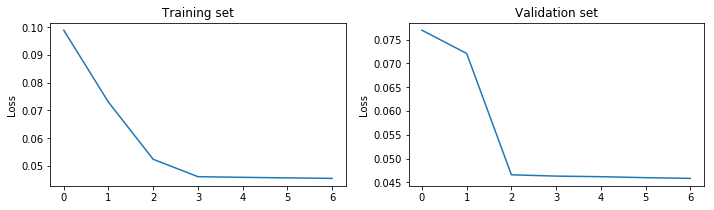

In [10]:
fig,axs=plt.subplots(1,2,figsize=(10,3))
axs[0].plot(range(len(his.history['loss'])),his.history['loss'])
axs[0].set_title("Training set")
axs[0].set_ylabel('Loss')
axs[1].plot(range(len(his.history['val_loss'])),his.history['val_loss'])
axs[1].set_title("Validation set")
axs[1].set_ylabel('Loss')
fig.tight_layout(pad=1.0)
plt.show()

#### **Testing in train model**
Let's apply one of the files in our testing set as an example.

First, we still need to filter out the noise, so I applied the same procedure as above to clean the outliers in new data. 

Second, I need to set a threshold for the scores obtained from the autoencoder. Here, I used the value that on 99% of the ranked scores array as the threshold value.


This threshold can help us to find out where the anomaly points are. If the score of the point is higher than the threshold then that point is an anomaly point.

I also created a "Reconstruction errors" plot which is based on the scores that obtained. This plot can help us to see more clearly that when did the machine entered into "faulty" status.



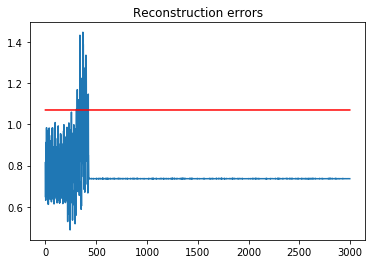

In [11]:
values1=pd.DataFrame()
temp= pd.read_csv("machine_18.csv", header=0)
a=temp.mean()+3*temp.std() 
mod=temp

for y in range(4):
  mod=mod.drop(mod[(abs(mod["%s"%y]) > a[y])|(abs(mod["%s"%y]) < 0.1)].index)
mod=mod[:round(len(mod)*0.5)]

for y in range(4):
  for z in range(len(temp)):
    if abs(temp.iloc[z, y+1]) > a[y]:
      temp.iloc[z, y+1]=mod.mean()[y]

values1=temp.drop(temp.columns[0],axis=1)

# ensure all data is float
values1 = values1.astype('float64')
# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled1 = scaler.fit_transform(values1)
# frame as supervised learning
reframed1 = series_to_supervised(scaled1, 2, 1)
scores = lae.predict(reframed1.values)

# Setting Threshold
ratio = 0.99
sorted_scores = sorted(scores)
threshold = sorted_scores[round(len(scores) * ratio)]

# Plot Reconstruction Errors 
plt.plot(scores)
plt.plot([threshold]*len(scores), c='r')
plt.title("Reconstruction errors")
plt.show() 



#### **Sanity checking**

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the "Reconstruction errors" plot is pretty clear, it's always good to check that there aren't obvious bugs. Therefore, I plotted the anomaly points as a scatter graph(red), along with the normal points(blue).


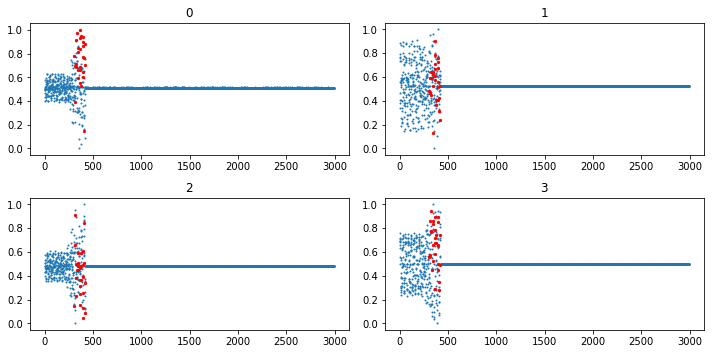

In [12]:
anomaly_idx = np.where(scores > threshold)
normal_idx = np.where(scores <= threshold)

fig,axs=plt.subplots(2,2,figsize=(10,5))
axs[0,0].scatter(normal_idx, reframed1.values[normal_idx][:, -1], s=1)
axs[0,0].scatter(anomaly_idx, reframed1.values[anomaly_idx][:, -1], c='r', s=5)
axs[0,0].set_title("0")
axs[0,1].scatter(normal_idx, reframed1.values[normal_idx][:, -2], s=1)
axs[0,1].scatter(anomaly_idx, reframed1.values[anomaly_idx][:, -2], c='r', s=5)
axs[0,1].set_title("1")
axs[1,0].scatter(normal_idx, reframed1.values[normal_idx][:, -3], s=1)
axs[1,0].scatter(anomaly_idx, reframed1.values[anomaly_idx][:, -3], c='r', s=5)
axs[1,0].set_title("2")
axs[1,1].scatter(normal_idx, reframed1.values[normal_idx][:, -4], s=1)
axs[1,1].scatter(anomaly_idx, reframed1.values[anomaly_idx][:, -4], c='r', s=5)
axs[1,1].set_title("3")
fig.tight_layout(pad=1.0)
plt.show()

We can further output the timestamps for those anomaly points. Here I only output the first 5 anomaly timestamps as an example.

In [13]:
# print(anomaly_idx)
anomalytime=pd.DataFrame(data=temp.values[anomaly_idx][:, 0],columns=['Timestamp'])
anomalytime.head(5)

,Timestamp
0,2019-04-13 00:48:58.579526509
1,2019-04-15 08:50:05.801933978
2,2019-04-15 16:50:15.405135046
3,2019-04-18 00:51:22.627542514
4,2019-04-20 16:52:39.453151050


#### **Summary**

For the last set of graphs, we can see when the machine is operating in the "normal" state, the data are more concentrated. When the machine entering to "faulty" state, the data are more fluctuated. And finally, all the data are close to 0 which means the machine is in "failed" states. 

We also can observe that the red points (anomaly points) we predicted are all in the "faulty" state. In the other words, if there are more than one consecutive timestamps are reported as anomaly data, this means the machine is entering to "faulty" state and the company should do something as soon as possible to avoid it going to the "failed" state.

The Long Short-Term Memory (LSTM) autoencoder that I use is pretty reliable because the encoder part of the model can be used to encode or compress sequence data (features) and the decoder part of the model can be used to outputs a prediction for the target sequence. But there are still some limitations to this approach. 

First, this approach is trained by the same type of machine signal. The signals that we have captured are kind of similar, but if there is a different type of machine then this approach might not perform well. Second, the sensitivity of the detection has heavily relied on the threshold that we set. If the value is too low, then we might have many false alarms which might also not good for the company. There are still other machine learning algorithms we can apply in future work, such as CNN and RNN. Also, we can tune the different hyperparameters in the neural network, such as hidden layer, optimizer, epoch, batch_size...etc. 